# **Regressione e Predizione con LSTM sui prezzi dei futures del Legname**

Caricamento ed analisi del dataset

In [ ]:
import pandas as pd
import numpy as np
dataset = pd.read_csv('Lumber Futures Historical Data (9).csv')
dataset = dataset.iloc[::-1].reset_index(drop=True)
dataset.index = dataset.pop('Date')
dataset.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
01/03/2000,350.3,352.0,354.8,350.2,0.24K,0.37%
01/04/2000,357.9,351.5,358.0,349.0,0.42K,2.17%
01/05/2000,354.8,359.0,359.8,354.7,0.33K,-0.87%
01/06/2000,352.4,355.5,355.6,351.2,0.23K,-0.68%
01/07/2000,354.5,354.0,357.0,352.5,0.20K,0.60%


In [ ]:
df = dataset.drop(['Price'], axis=1)
df.head()

,Open,High,Low,Vol.,Change %
Date,,,,,
01/03/2000,352.0,354.8,350.2,0.24K,0.37%
01/04/2000,351.5,358.0,349.0,0.42K,2.17%
01/05/2000,359.0,359.8,354.7,0.33K,-0.87%
01/06/2000,355.5,355.6,351.2,0.23K,-0.68%
01/07/2000,354.0,357.0,352.5,0.20K,0.60%


In [ ]:
dataset.keys()

Index(['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 01/03/2000 to 11/15/2019
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     5000 non-null   float64
 1   Open      5000 non-null   float64
 2   High      5000 non-null   float64
 3   Low       5000 non-null   float64
 4   Vol.      4940 non-null   object 
 5   Change %  5000 non-null   object 
dtypes: float64(4), object(2)
memory usage: 273.4+ KB


Grafico andamento dei prezzi minimi e massimi

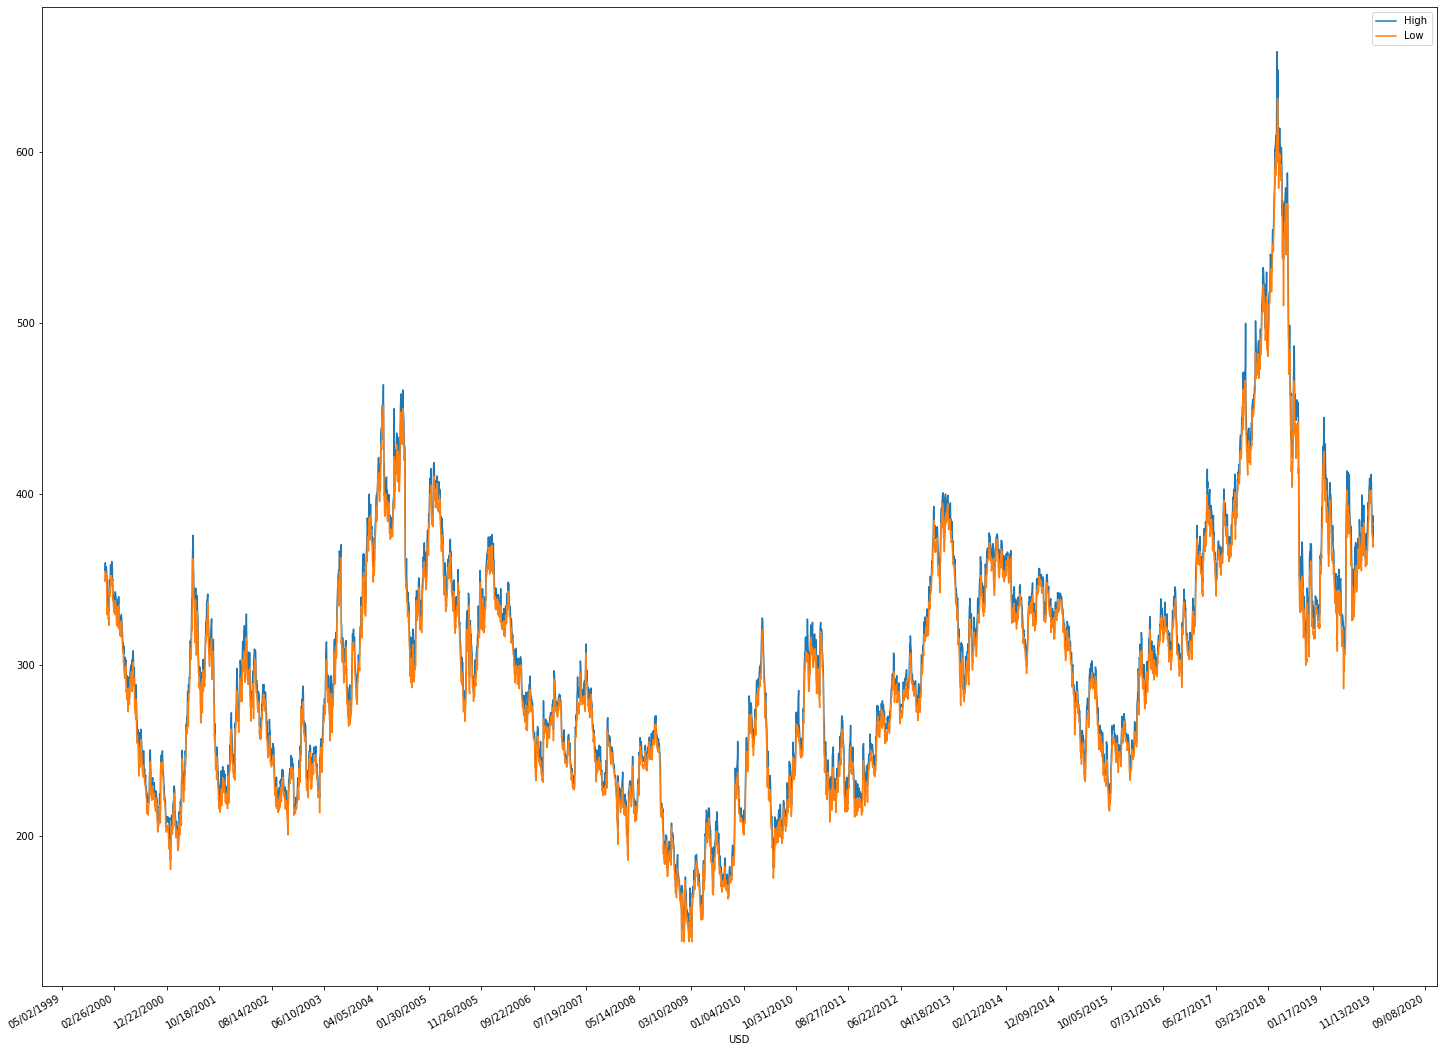

In [ ]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import datetime as dt

plt.figure(figsize=(25,20))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=300))
x_dates=[dt.datetime.strptime(d,'%m/%d/%Y').date() for d in dataset.index.values]

plt.plot(x_dates, dataset['High'], label='High')
plt.plot(x_dates, dataset['Low'], label='Low')
plt.xlabel('Time Scale')
plt.xlabel('USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

Costruzione della RNN

In [ ]:
# Import delle librerie di keras e sklearn
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# Deinizione target e dati in esame
x = df.iloc[:,0:3]
y = dataset['Price']
print(x)
print(y)
print(x.shape)
print(y.shape)

             Open   High    Low
Date                           
01/03/2000  352.0  354.8  350.2
01/04/2000  351.5  358.0  349.0
01/05/2000  359.0  359.8  354.7
01/06/2000  355.5  355.6  351.2
01/07/2000  354.0  357.0  352.5
...           ...    ...    ...
11/11/2019  376.3  379.9  375.0
11/12/2019  376.0  381.5  372.0
11/13/2019  370.0  373.1  369.0
11/14/2019  378.2  387.3  370.5
11/15/2019  380.0  383.9  374.2

[5000 rows x 3 columns]
Date
01/03/2000    350.3
01/04/2000    357.9
01/05/2000    354.8
01/06/2000    352.4
01/07/2000    354.5
              ...  
11/11/2019    377.0
11/12/2019    372.2
11/13/2019    372.6
11/14/2019    382.0
11/15/2019    375.7
Name: Price, Length: 5000, dtype: float64
(5000, 3)
(5000,)


In [ ]:
# Scaling dei dati
sc=StandardScaler()
sc1=StandardScaler()
x_ft=sc.fit_transform(x.values)
x_ft=pd.DataFrame(columns=x.columns,data=x_ft,index=x.index)
yr = y.values.reshape(-1,1)
y_ft=sc1.fit_transform(yr)

In [ ]:
# Divisione in Training e Test set
def lstm_split(data,n_steps):
  X,Y=[],[]
  for i in range(len(data)-n_steps+1):
    X.append(data[i:i+n_steps,:-1])
    Y.append(data[i+n_steps-1,-1])
  return np.array(X),np.array(Y)

n_steps=2
x1,y1=lstm_split(x_ft.values, n_steps=n_steps)
train_split=0.8
split_idx=int(np.ceil(len(x1)*train_split))
date_index=x_ft.index

x_train,x_test=x1[:split_idx],x1[split_idx:]
y_train,y_test=y1[:split_idx],y1[split_idx:]
x_train_date,x_test_date=date_index[:split_idx],date_index[split_idx:-(n_steps-1)]

print(x1.shape, x_train.shape, x_test.shape, x_test_date.shape, y_test.shape)

(4999, 2, 2) (4000, 2, 2) (999, 2, 2) (999,) (999,)


In [ ]:
# Creazione modello dell'LSTM
lstm = Sequential()
lstm.add(LSTM(50, return_sequences=True, activation='relu', input_shape = (x_train.shape[1], x_train.shape[2]))),
lstm.add(LSTM(50, activation='relu'))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
lstm.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 50)             10600     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,851
Trainable params: 30,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history=lstm.fit(x_train,y_train, epochs=30,batch_size=4,verbose=2,shuffle=False)

Epoch 1/30
1000/1000 - 5s - loss: 0.0435 - 5s/epoch - 5ms/step
Epoch 2/30
1000/1000 - 4s - loss: 0.0043 - 4s/epoch - 4ms/step
Epoch 3/30
1000/1000 - 6s - loss: 0.0034 - 6s/epoch - 6ms/step
Epoch 4/30
1000/1000 - 5s - loss: 0.0029 - 5s/epoch - 5ms/step
Epoch 5/30
1000/1000 - 3s - loss: 0.0029 - 3s/epoch - 3ms/step
Epoch 6/30
1000/1000 - 3s - loss: 0.0031 - 3s/epoch - 3ms/step
Epoch 7/30
1000/1000 - 3s - loss: 0.0029 - 3s/epoch - 3ms/step
Epoch 8/30
1000/1000 - 4s - loss: 0.0028 - 4s/epoch - 4ms/step
Epoch 9/30
1000/1000 - 4s - loss: 0.0028 - 4s/epoch - 4ms/step
Epoch 10/30
1000/1000 - 3s - loss: 0.0026 - 3s/epoch - 3ms/step
Epoch 11/30
1000/1000 - 3s - loss: 0.0024 - 3s/epoch - 3ms/step
Epoch 12/30
1000/1000 - 3s - loss: 0.0024 - 3s/epoch - 3ms/step
Epoch 13/30
1000/1000 - 3s - loss: 0.0023 - 3s/epoch - 3ms/step
Epoch 14/30
1000/1000 - 3s - loss: 0.0023 - 3s/epoch - 3ms/step
Epoch 15/30
1000/1000 - 3s - loss: 0.0022 - 3s/epoch - 3ms/step
Epoch 16/30
1000/1000 - 3s - loss: 0.0022 - 3s/ep

In [ ]:
#Predizioni
y_pred=lstm.predict(x_test)
y_test=y_test.reshape(-1,1)
y_testr=sc1.inverse_transform(y_test)
y_predr=sc1.inverse_transform(y_pred)

32/32 [==============================] - 0s 2ms/step


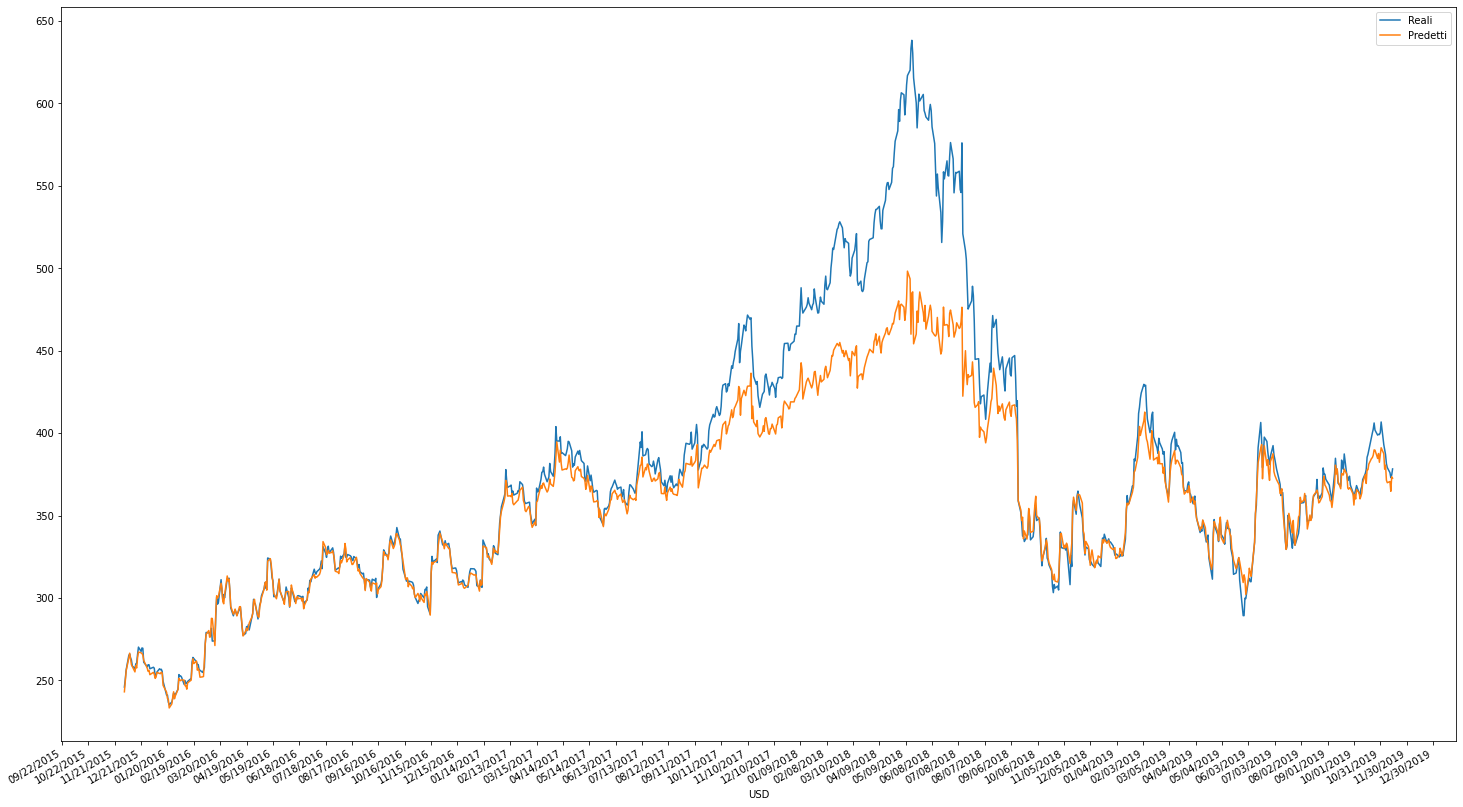

In [ ]:
plt.figure(figsize=(25,15))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
x_dates=[dt.datetime.strptime(d,'%m/%d/%Y').date() for d in x_test_date]

plt.plot(x_dates, y_testr, label='Reali')
plt.plot(x_dates, y_predr, label='Predetti')
plt.xlabel('Time Scale')
plt.xlabel('USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

In [ ]:
import seaborn as sns
from sklearn import metrics

In [ ]:
data0 = pd.DataFrame(y_testr)
print(data0)

data = pd.DataFrame(y_predr)
print(data)

              0
0    245.998096
1    250.644337
2    256.401636
3    265.088087
4    266.098139
..          ...
994  379.123003
995  376.092846
996  373.062689
997  374.577768
998  378.314961

[999 rows x 1 columns]
              0
0    243.117355
1    249.267700
2    255.858887
3    263.597961
4    266.551483
..          ...
994  369.951721
995  370.669891
996  364.752777
997  373.544891
998  372.683624

[999 rows x 1 columns]


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


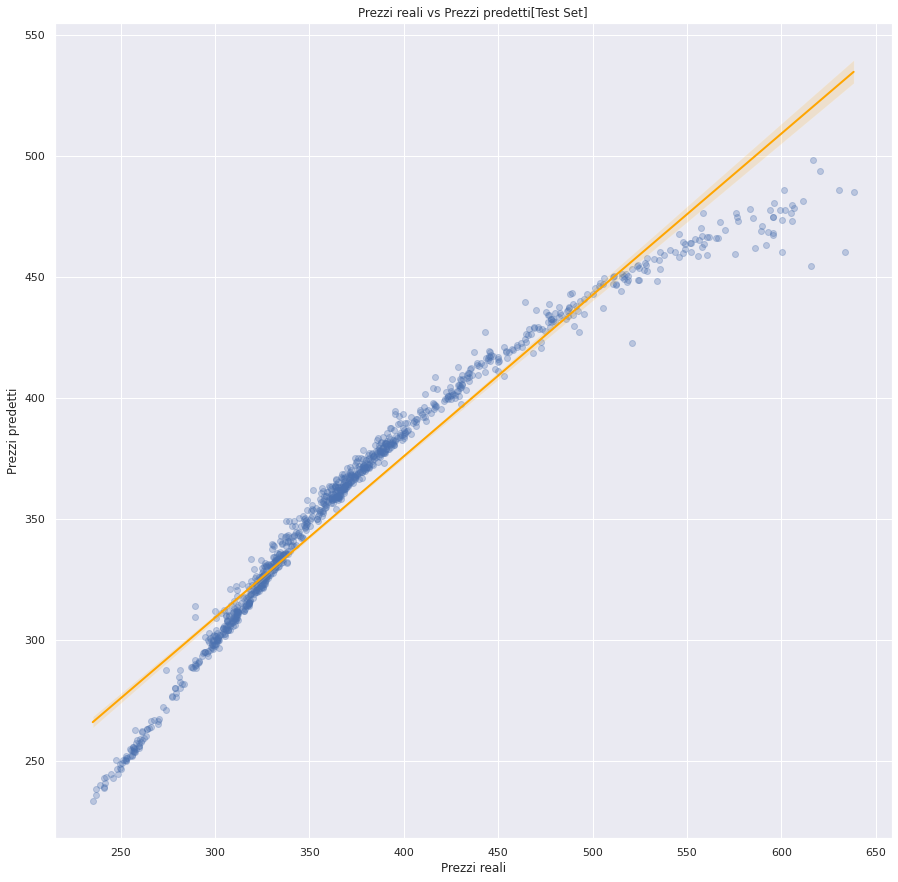

In [ ]:
sns.set(rc={'figure.figsize':(15,15)})
sns.regplot(y_testr, y_predr, scatter_kws={'alpha':0.3}, line_kws={'color':'orange', 'linewidth': 2})
 
plt.xlabel("Prezzi reali")
plt.ylabel("Prezzi predetti")
plt.title("Prezzi reali vs Prezzi predetti[Test Set]")
 
plt.show()

In [ ]:
rmse_test1 = np.sqrt(mean_squared_error(y_testr, y_predr))
r2_test1 = r2_score(y_testr, y_predr)

print('Model accuracy (%)')
print((1-(metrics.mean_absolute_error(y_testr, y_predr)/y_testr.mean()))*100)

print("Performance del modello per il test set:")
print("RMSE del test set è {}".format(rmse_test1))
print("R2 del test set è {}".format(r2_test1))

Model accuracy (%)
95.37496468926717
Performance del modello per il test set:
RMSE del test set è 33.86641062832058
R2 del test set è 0.824878529005684
